# Grover's Example

#### Uncomment the cell below to pip install the necessary modules if not already installed

#### Note: Works with Qiskit Version 1.4.1 and Quantum Rings Qiskit Toolkit Version 0.1.10

In [6]:
# %pip install QuantumRingsLib
# %pip install qiskit==1.4.1
# %pip install quantumrings-toolkit-qiskit==0.1.10

#### Restart the kernel after installing any of the missing packages

### Introduction

Amplitude amplification is a general purpose quantum algorithm, or subroutine, that can be used to obtain a quadratic speedup over a handful of classical algorithms. [Grover’s algorithm](https://arxiv.org/abs/quant-ph/9605043) was the first to demonstrate this speedup on unstructured search problems. Formulating a Grover's search problem requires an oracle function that marks one or more computational basis states as the states we are interested in finding, and an amplification circuit that increases the amplitude of marked states, consequently suppressing the remaining states.

Here we demonstrate how to construct Grover oracles and use the `GroverOperator` from the Qiskit circuit library to easily set up a Grover's search instance. We will use Quantum Rings Qiskit Toolkit to implement the runtime `Sampler` for the execution of the Grover circuits.

In [1]:
# Where to find this example?
# https://learning.quantum.ibm.com/tutorial/grovers-algorithm

#### Setup

We will start by importing the tools we need for this tutorial

In [1]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Quantum Rings
import QuantumRingsLib
from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2
from quantumrings.toolkit.qiskit import QrSamplerV2 as Sampler

We then want to activate our Quantum Rings account. The cell below assumes that you have the account saved locally. If you have not done this please reference [how to save the Quantum Rings account locally](https://portal.quantumrings.com/doc/Installation.html#saving-the-quantum-rings-account-locally) page.

In [2]:
provider = QuantumRingsProvider()
backend = QrBackendV2(provider, num_qubits=5)

backend.name

'scarlet_quantum_rings'

Let's define our Grover oracle function.

In [3]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
        
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
        
    return qc

#### Specific Grover's instance

Now that we have the oracle function, we can define a specific instance of the Grover search. In this example, we will mark two computational states out of the eight available in a three-qubit computational space.

/tmp/ipykernel_28237/1866981481.py:31: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)


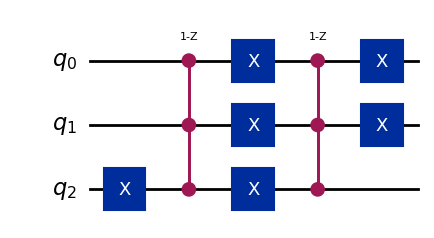

In [4]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

#### GroverOperator

The built-in Qiskit `GroverOperator` takes an oracle circuit and returns a circuit that is composed of the oracle circuit itself and a circuit that amplifies the states marked by the oracle. We will `decompose` the circuit to see the gates within the operator:

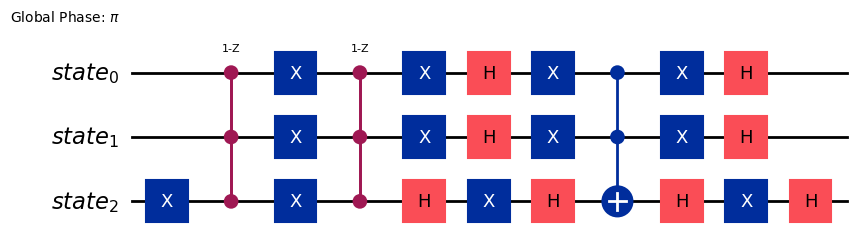

In [5]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

Repeated applications of this `grover_op` circuit amplify the marked states, making them the most probable bit-strings in the output distribution from the circuit. There is an optimal number of such applications that is determined by the ratio of marked states to total number of possible computational states:

In [6]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

#### Full Grover circuit

A complete Grover experiment starts with a Hadamard gate on each qubit. This creates an even superposition of all computational basis states. This is followed by the Grover operator (`grover_op`) repeated the optimal number of times. Here we make use of the `QuantumCircuit.power(INT)` method to repeatedly apply the Grover operator.

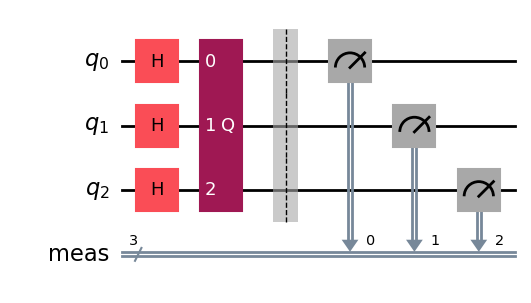

In [7]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

### Optimize the problem for quantum execution

Now that we have our circuit set up in an abstract manner. We need to transpile the circuit so that it is runnable on a quantum computer. We will use `generate_preset_pass_manager` to transpile our circuit and print it out. This essentially converts our circuit in to an Instruction Set Architecture (ISA) and has been demonstrated in previous notebooks, so hopefully looks familiar.

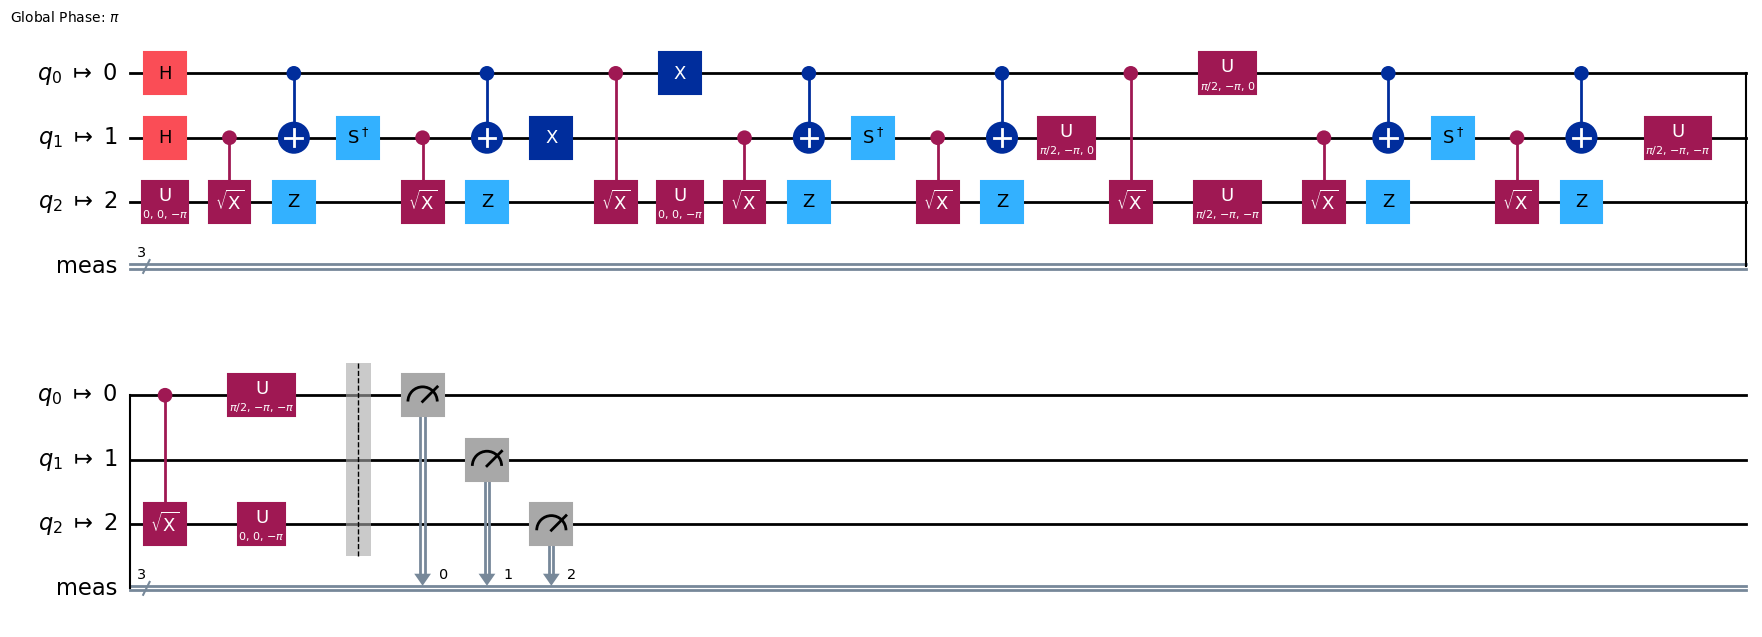

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

### Execute

Amplitude amplification is a sampling problem that is suitable for execution with the `Sampler` runtime. This is where we will use the Quantum Rings Qiskit Toolkit implementation of the `Sampler` primitive.

In [11]:
sampler = Sampler(backend=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

### Post-process: Return the result in classical format

We will plot the resulting distribution below. One thing to note here is that if we compare this with the output from [IBMs Grover Algorithm](https://learning.quantum.ibm.com/tutorial/grovers-algorithm), the resulting plot below differs. This is due to the difference in the IBM example running on their freely accessible quantum computer, and our example running through a simulation of quantum computing qubits. The advantage of using the simulation software comes from the accessibility and scaling.

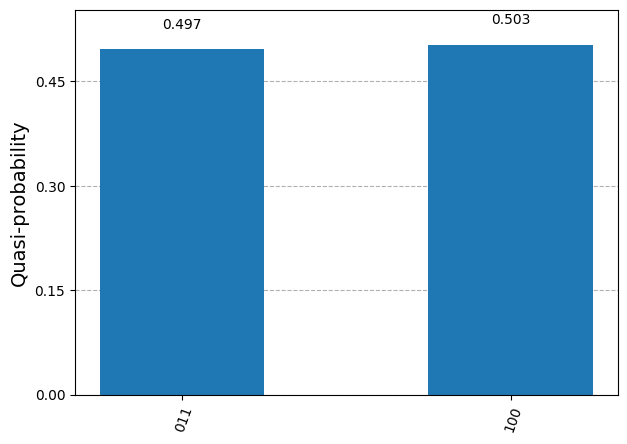

In [13]:
plot_distribution(dist)

### Conclusion

Congratualtions! You have completed a short example of Grover's Algorithm. The plot above shows the two most probable states that the algorithm found. The overall idea of the algorithm is to improve search methods by performing the probability amplitude amplification. This is done with the use of the Grover oracle. The result does still end up being probabilistic, but if the process continues it will generate a probability high enough to be "certain". Touching on the note from above, if we compare this output with that of IBMs output from a real quantum computer, we see that there are less states, but that the two states shown above are the same states that their output displays with the highest probability. This helps to reassure that we are indeed finding the proper answer, and shows how simulation can be a good assessor when first testing algorithms for quantum computing. For more information on Grover's algorithm, feel free to check out the [original paper](https://arxiv.org/abs/quant-ph/9605043).